## Setup
# RotNet CiFar 2 (Perfect only)

In [1]:
##
## Restrict tensorflow to single GPU
##
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)           
## this says only use GPU 0  (can select 0-3)

##
## Import libraries
##
import evm_flat         ## We are using EVMs for a different project, so there are some things in here that may be confusing
from utils import *     ## utils holds a few functions I wrote to help with the experiments in this notebook
import numpy as np
import tensorflow as tf

##
## Experiment Parameters
##
epochs = 10                 ## Iterations to train CNN for feature extractors
num_to_remove = 2           ## Number of classes to remove and make "unknown"
iterations = 30             ## Number of iterations (full experiments) to run
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  ## Confidence thresholds to evaluate over

##
## EVM Parameters (good initial values, but could be further optimized)
##
tailsize = 10000              ## EVM tail size
cover_threshold = 0.5      ## EVM cover threshold
dist_func = 'cosine'     ## EVM distance function
num_to_fuse = 4             ## EVM number to fuse
margin_scale = 0.5          ## EVM margin scale

## Data

In [2]:
##
## Load CiFar10
##
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

##
## Get data in correct shape and normalize
##
#x_train = x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))/255.0   ## Add dimension and normalize
#x_test = x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))/255.0         ## Add dimension and normalize
#y_train = tf.keras.utils.to_categorical(y_train)     ## Make one-hot
#y_test = tf.keras.utils.to_categorical(y_test)       ## Make one-hot

In [3]:
import numpy as np
import os
import random
import sklearn
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn import metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
#import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'SelfSupervision-main/cifar-10-batches-py/test_batch'
    else:
        name = 'SelfSupervision-main/cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [6]:
rotations_num = 4
augment_num = 10

saved_name = 'selfsupervised'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [7]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)


for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

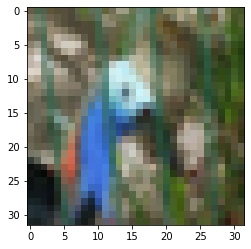

[1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


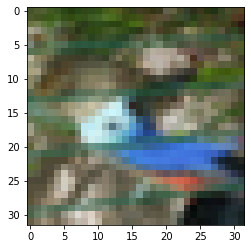

[0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


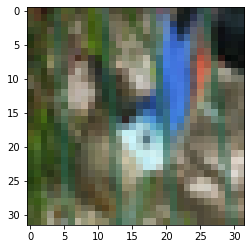

[0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


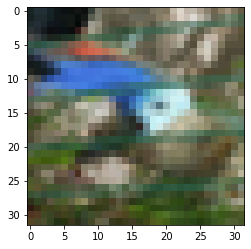

[0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [9]:
#print(len(files[2][b"labels"]))

In [10]:
# def get_conv_model_modded():
#     base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
#     l = base.get_layer(feature_layer_trained).output
#     l = layers.Flatten()(l)
#     l = layers.BatchNormalization()(l)
#     l = layers.Dropout(0.5)(l)
#     l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform', name = 'good layer')(l)
#     l = layers.BatchNormalization()(l)
#     l = layers.Activation('relu')(l)
#     l = layers.Dropout(0.5)(l)
#     l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform',
#                      name = 'good_layer')(l)
#     l = layers.BatchNormalization()(l)
#     l = layers.Activation('relu')(l)
#     l = layers.Dropout(0.5)(l)
#     l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
#     return tensorflow.keras.Model(inputs = base.input, outputs = base.get_layer('good layer').output)

def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform', name = 'good_layer')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tensorflow.keras.Model(inputs = base.input, outputs = l)

def self_supervised_train(unlabeled, percent, use_datagen = False, **kwargs):
    if percent >= 100:
        return None
    
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    if use_datagen:
        log = model.fit(kwargs['datagen'].flow(np.asarray([combined_data[i] for i in unlabeled]), 
                    np.asarray([combined_labels[i] for i in unlabeled]),
                    batch_size = selfsupervised_batch_size),
                    epochs = selfsupervised_epochs, 
                    steps_per_epoch = len(unlabeled) // selfsupervised_batch_size,
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray(combined_data[50000 * rotations_num:]), 
                                               np.asarray(combined_labels[50000 * rotations_num:])))
    else:    
        log = model.fit(np.asarray([combined_data[i] for i in unlabeled]) / 256., 
                    np.asarray([combined_labels[i] for i in unlabeled]), 
                    epochs = selfsupervised_epochs, 
                    batch_size = selfsupervised_batch_size, 
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)])  / 256., 
                                               np.asarray([combined_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    model.save(saved_name + "_" + str(percent))
    
    return log, model

In [11]:
feat_log, great_model = self_supervised_train([i for i in range(50000 * rotations_num)], 0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Create Feature Extractor With Perfect Knowledge 

- Feature extractor is a CNN trained using ALL of the classes
- This is not realistic in the real world because all of the classes will not be known
- This is a good "optimal" feature space to compare against
- Goal would be to get as close to this performance as possible

In [12]:
rotNet_features=tensorflow.keras.Model(inputs = great_model.input, outputs = great_model.get_layer('good_layer').output)

In [13]:
import keras.utils
y_train=tf.keras.utils.to_categorical(y_train) #one hot encoding the y vectors 
y_test=tf.keras.utils.to_categorical(y_test)

## Define a set of experiments

- Randomly select and remove classes from the training data
- Split test data into known and unknown classes
- Fit imperfect feature extraction model
- Extract features using the perfect and imperfect extractors
- Fit EVM using features for the perfect and imperfect
- Evaluate performance (evaluation metrics may need to be improved, but this gives us an initial idea of performance)
- Repeat


In [16]:
import pandas as pd
##
## Define places to store results
##
#imp_known_correct_all = []
#imp_known_novel_all = []
#imp_unknown_correct_all = []
#imp_unknown_novel_all = []
per_known_correct_all = []
per_known_novel_all = []
per_unknown_correct_all = []
per_unknown_novel_all = []


df = pd.DataFrame(columns=['Iteration', 'Unknown Classes', 'per_known_correct_all','per_known_novel_all','per_unknown_novel_all'])
##
## Begin experiments
##
for i in range(iterations):
    print('Iteration: ' + str(i))
    print()
    
    ##
    ## Split the data into known and unknown classes
    ##
    toRemove = np.random.choice(10, num_to_remove, replace = False)                                         ## Randomly pick unknown classes
    x_train_known, x_train_unknown, y_train_known, y_train_unknown = split_data(x_train, y_train, toRemove) ## Split train data (defined in utils.py)
    x_test_known, x_test_unknown, y_test_known, y_test_unknown = split_data(x_test, y_test, toRemove)       ## Split test data (defined in utils.py)

    ##
    ## Train a classifier based feature extractor using only the known classes
    ##
    #imperfect = feature_model(10-num_to_remove, x_train_known, y_train_known, epochs = epochs, batch_size = 32, verbose = 0)

    ##
    ## Extract features with imperfect extractor
    ##
    #x_train_known_imp = imperfect.predict(x_train_known)
    #x_test_known_imp = imperfect.predict(x_test_known)
    #x_test_unknown_imp = imperfect.predict(x_test_unknown)

    ##
    ## Extract features with perfect extractor
    ##
    x_train_known_per = rotNet_features.predict(x_train_known)
    x_test_known_per = rotNet_features.predict(x_test_known)
    x_test_unknown_per = rotNet_features.predict(x_test_unknown)

    ##
    ## Fit EVMs
    ##
    evm_options = evm_flat.EVMOptions(tailsize = tailsize, cover_threshold = cover_threshold , dist_func = dist_func, num_to_fuse = num_to_fuse, margin_scale = margin_scale)
    
    #print('Fit Imperfect EVM')
    #evm_imp = evm_flat.ExtremeValueMachine('imperfect', evm_options)
    #evm_imp.train(x_train_known_imp, y_train_known)
    print('Fit Perfect EVM')
    evm_per = evm_flat.ExtremeValueMachine('perfect', evm_options)
    evm_per.train(x_train_known_per, y_train_known)

    ##
    ## Make Predictions with EVM
    ##
    #imp_pred_known = evm_imp.confidence(x_test_known_imp)
    #imp_pred_unknown = evm_imp.confidence(x_test_unknown_imp)
    per_pred_known = evm_per.confidence(x_test_known_per)
    per_pred_unknown = evm_per.confidence(x_test_unknown_per)

    ##
    ## Evaluate Predictions
    ##
    #imp_known_correct, imp_known_novel = eval(imp_pred_known, y_test_known, thresholds)           ## eval defined in utils.py
    #imp_unknown_correct, imp_unknown_novel = eval(imp_pred_unknown, y_test_unknown, thresholds)
    per_known_correct, per_known_novel = eval(per_pred_known, y_test_known, thresholds)
    per_unknown_correct, per_unknown_novel = eval(per_pred_unknown, y_test_unknown, thresholds)
    
    ##
    ## Store results
    ##
    #imp_known_correct_all.append(imp_known_correct)      ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
    #imp_known_novel_all.append(imp_known_novel)          ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
    #imp_unknown_novel_all.append(imp_unknown_novel)      ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
    per_known_correct_all.append(per_known_correct)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
    per_known_novel_all.append(per_known_novel)          ## per_known_novel: percentage of known instances called novel by the perfect EVM
    per_unknown_novel_all.append(per_unknown_novel)      ## per_unknown_novel: percentage of unknown instances called novel by the perfect EVM
    if i <= 5:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./rotNet_df_cf5_five_iter(s).csv', index= False,header=True)
        df.to_csv(r'./rotNet_df_cf5.csv', index= False,header=True)
    else:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./rotNet_df_cf5.csv', index= False,header=True)

Iteration: 0

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 1

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 2

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 3

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 4

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 5

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 6

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 7

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 8

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 9

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 10

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 11

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 12

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 13

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 14

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 15

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 16

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 17

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 18

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 19

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 20

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 21

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 22

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 23

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 24

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 25

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 26

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 27

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 28

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 29

Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/RotNet/utils.py:125: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


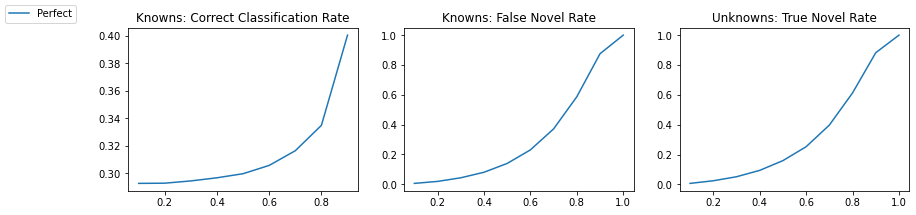

In [18]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

#ax1.plot(thresholds, np.mean(imp_known_correct_all, axis = 0), label = 'Imperfect')
ax1.plot(thresholds, np.mean(per_known_correct_all, axis = 0), label = 'Perfect')


#ax2.plot(thresholds, np.mean(imp_known_novel_all, axis = 0), label = 'Imperfect')
ax2.plot(thresholds, np.mean(per_known_novel_all, axis = 0), label = 'Perfect')

#ax3.plot(thresholds, np.mean(imp_unknown_novel_all, axis = 0), label = 'Imperfect')
ax3.plot(thresholds, np.mean(per_unknown_novel_all, axis = 0), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.savefig('RotNet_images_cf2_30iter.pdf')
plt.show()